## 1. Business Problem

### 1.1 Description

Ordering food supplies online is a new way of restocking groceries or products. Be it early morning or midnight, ordering groceries online is stress-free activity without much hassle. But what happens when you forget few items while adding items to the cart or want to get better suggestions on your items? Will you wait for a couple of hours and then order? To deal with such situations, users are provided with suggestions based on their past orders or user preferences.
Instacart, a grocery order, and the delivery app provide such a user experience where you will get product recommendations. These products can be reordered items or new recommendations.
Instacart provided us with transactional data of customer orders over time to predict which previously purchased products will be in a user’s next order. This data is open-sourced and given as a Kaggle challenge.


### 1.2 Real world/Business Objectives and Constraints 

The objective is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, instacart provided between 4 and 100 of their orders, with the order of products which were added to cart

## 2. Machine Learning Problem

### 2.1 Mapping the real world problem to an ML problem

Based on these order history and user preferences of the product, we need to predict the products which could be reordered.

This could help users to quickly add products to cart , rather than browsing through all products from different departments. As this model recommends products to the user based on his past order activity, a huge amount of time is saved , and hence improving overall revenue.

### 2.2 Type of ML problem

At first, it seems like Multi-Label Classification, but there are 49688 products, and total product recommendations could be anywhere from None to N. 
Therefore, this problem is restructured into a binary classification problem, where we will predict the probability of an item being reordered. 

For each order, we will group these probabilities to pick top K probable products which will be reordered, and recommend those to the user.


### 2.2 Performance Metric 

Mean F1-Score - Mean of all F1 Scores for every order.

Since we need to know how many of the actual recommended products match with predicted ones, we will use F1 score on each order. For all orders combined, we will take mean of those F1-scores 


In [1]:
#loading libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#overriding default setting of pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
#load all data files
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
prior_order = pd.read_csv('order_products__prior.csv')
train_order = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

print('aisles shape :', aisles.shape)
print('departments shape :',departments.shape)
print('prior_order shape :', prior_order.shape)
print('train_order shape :', train_order.shape)
print('orders shape :', orders.shape)
print('products shape :', products.shape)

aisles shape : (134, 2)
departments shape : (21, 2)
prior_order shape : (32434489, 4)
train_order shape : (1384617, 4)
orders shape : (3421083, 7)
products shape : (49688, 4)


In [3]:
aisles.head(5)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
departments.head(5)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
prior_order.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
train_order.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


## 3. Data Preprocessing

### Filling Missing Values

In [9]:
#check missing values

print("="*10 + "aisles.csv" + "="*10)
print(aisles.isnull().sum(axis = 0))
print()

print("="*10 + "departments.csv" + "="*10)
print(departments.isnull().sum(axis = 0))
print()

print("="*10 + "order_products__prior.csv" + "="*10)
print(prior_order.isnull().sum(axis = 0))
print()

print("="*10 + "order_products__train.csv" + "="*10)
print(train_order.isnull().sum(axis = 0))
print()

print("="*10 + "orders.csv" + "="*10)
print(orders.isnull().sum(axis = 0))
print()

print("="*10 + "products.csv" + "="*10)
print(products.isnull().sum(axis = 0))
print()

==========aisles.csv==========
aisle_id    0
aisle       0
dtype: int64

==========departments.csv==========
department_id    0
department       0
dtype: int64

==========order_products__prior.csv==========
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

==========order_products__train.csv==========
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

==========orders.csv==========
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

==========products.csv==========
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64



In [10]:
#find missing values in orders.csv
print("% of data which has missing values ")
print(orders.isnull().sum()/orders.shape[0])


print("\n% of unique users vs total data : ",orders.user_id.nunique()/len(orders))

% of data which has missing values 
order_id                  0.000000
user_id                   0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    0.060276
dtype: float64

% of unique users vs total data :  0.06027594185817766


In [11]:
#check if null values are present only for 1st orders of all users
orders[orders['order_number']==1].isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

__conclusion__:

For every user's first order , days_since_prior_order is left empty .
It is safe to impute 0 here .


In [12]:
#imputation
orders.fillna(value = 0, inplace = True)

### Merging Data

To check interdependency of variables with each other , we will merge few tables together

In [13]:
#merge order_products__prior and order_products__train

prior_train_orders = pd.concat([prior_order, train_order]).sort_values(by=['order_id'])
print("Shape of prior_train_orders :", prior_train_orders.shape)
prior_train_orders.head(20)

Shape of prior_train_orders : (33819106, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
1,1,11109,2,1
0,2,33120,1,1
1,2,28985,2,1


In [14]:
#merge prior_train_orders and products

prior_train_orders = pd.merge(left = prior_train_orders, right = products,
                             left_on='product_id', right_on='product_id').sort_values(by=['order_id']).reset_index(drop=True)

print("Shape of prior_train_orders :", prior_train_orders.shape)
prior_train_orders.head(10)

Shape of prior_train_orders : (33819106, 7)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15
2,1,13176,6,0,Bag of Organic Bananas,24,4
3,1,47209,7,0,Organic Hass Avocado,24,4
4,1,22035,8,1,Organic Whole String Cheese,21,16
5,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
6,1,10246,3,0,Organic Celery Hearts,83,4
7,1,49683,4,0,Cucumber Kirby,83,4
8,2,17794,6,1,Carrots,83,4
9,2,9327,3,0,Garlic Powder,104,13


In [15]:
#merge prior_train_orders and aisles

prior_train_orders = pd.merge(left = prior_train_orders, right = aisles,
                             left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)

print("Shape of prior_train_orders :", prior_train_orders.shape)

Shape of prior_train_orders : (33819106, 8)


In [16]:
#merge prior_train_orders and departments

prior_train_orders = pd.merge(left = prior_train_orders, right = departments,
                             left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)

print("Shape of prior_train_orders :", prior_train_orders.shape)
prior_train_orders.head(20)

Shape of prior_train_orders : (33819106, 9)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce
2,1,13176,6,0,Bag of Organic Bananas,24,4,fresh fruits,produce
3,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods
4,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce
5,1,47209,7,0,Organic Hass Avocado,24,4,fresh fruits,produce
6,1,22035,8,1,Organic Whole String Cheese,21,16,packaged cheese,dairy eggs
7,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
8,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
9,2,43668,9,0,Classic Blend Cole Slaw,123,4,packaged vegetables fruits,produce


In [17]:
#merge prior_train_orders with orders
# since orders have all prior/train/test data, we will merge only prior and train orders for EDA , but leave test orders untouched

prior_train_orders = pd.merge(left = prior_train_orders, right = orders,
                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)

print("Shape :", prior_train_orders.shape)
prior_train_orders.head(10)

Shape : (33819106, 15)


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0
1,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
2,1,13176,6,0,Bag of Organic Bananas,24,4,fresh fruits,produce,112108,train,4,4,10,9.0
3,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0
4,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
5,1,47209,7,0,Organic Hass Avocado,24,4,fresh fruits,produce,112108,train,4,4,10,9.0
6,1,22035,8,1,Organic Whole String Cheese,21,16,packaged cheese,dairy eggs,112108,train,4,4,10,9.0
7,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9.0
8,2,17794,6,1,Carrots,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
9,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [18]:
col_order = ['user_id',
 'order_id',
 'product_id',
  'aisle_id',
 'department_id',
 'add_to_cart_order',
 'reordered',
 'product_name',
 'aisle',
 'department',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order']

prior_train_orders = prior_train_orders[col_order]

## 4. EDA

### 4.1 Univariate Analysis

In [19]:
prior_train_orders.head()

,user_id,order_id,product_id,aisle_id,department_id,add_to_cart_order,reordered,product_name,aisle,department,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,112108,1,49302,120,16,1,1,Bulgarian Yogurt,yogurt,dairy eggs,train,4,4,10,9.0
1,112108,1,49683,83,4,4,0,Cucumber Kirby,fresh vegetables,produce,train,4,4,10,9.0
2,112108,1,13176,24,4,6,0,Bag of Organic Bananas,fresh fruits,produce,train,4,4,10,9.0
3,112108,1,43633,95,15,5,1,Lightly Smoked Sardines in Olive Oil,canned meat seafood,canned goods,train,4,4,10,9.0
4,112108,1,10246,83,4,3,0,Organic Celery Hearts,fresh vegetables,produce,train,4,4,10,9.0


In [20]:
prior_train_orders['reordered'].value_counts()

1    19955360
0    13863746
Name: reordered, dtype: int64

#### 4.1.1 Target Variable Distribution ?

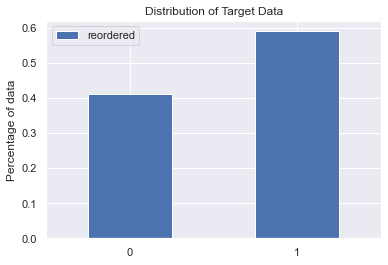

In [21]:
## Question : Target Variable Distribution ?

sns.set_theme()
ax = (prior_train_orders['reordered'].value_counts()/prior_train_orders.shape[0]).plot.bar()
ax.set_xticklabels(['1','0'], rotation = 0)  # convert it to first time orders and Reorders
ax.set_ylabel("Percentage of data")
ax.set_title('Distribution of Target Data')
ax.legend()

In [22]:
prior_set = prior_train_orders[prior_train_orders['eval_set']=='prior']
train_set = prior_train_orders[prior_train_orders['eval_set']=='train']

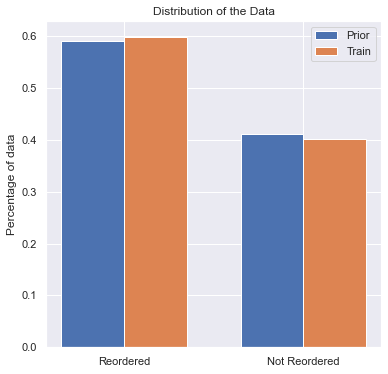

In [23]:
#plot distribution by percentage

prior_set = prior_set['reordered'].value_counts()/prior_set.shape[0]
train_set = train_set['reordered'].value_counts()/train_set.shape[0]

width = 0.35  
x = np.array([0,1])
fig, ax = plt.subplots(figsize=(6,6))
rects1 = ax.bar(x - width/2, prior_set, width, label='Prior')
rects2 = ax.bar(x + width/2, train_set, width, label='Train')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage of data')
ax.set_title('Distribution of the Data')
ax.set_xticks(x)
ax.set_xticklabels(['Reordered','Not Reordered'])
ax.legend()
plt.show()


__Analysis :__

- Distribution is similar in both Prior and Train Set
- Around 60% of time product has been reordered

#### 4.1.2 Users - How many users ?

In [24]:
print("Total Users :",prior_train_orders['user_id'].nunique())
print("Users in train :",prior_train_orders[prior_train_orders['eval_set']=='train']['user_id'].nunique())
print("Users in test :",orders[orders['eval_set']=='test']['user_id'].nunique())

Total Users : 206209
Users in train : 131209
Users in test : 75000


- Every User in Test set has prior orders in order_products_prior, similarly for every user in Train has order history in order_products_prior.

- So , we can conclude the train-test data is split on users 

#### 4.1.3 Orders - How many orders were placed by every user ?

In [25]:
#Question : How many orders were placed by every user ? 

orders_count = orders.groupby(['user_id'])['order_id'].agg(lambda group: len(group.unique()))\
                .reset_index(name='order_count')\
                .set_index('user_id')

In [26]:
print("Minimum orders per user :",orders_count['order_count'].min())
print("Maximum orders per user :",orders_count['order_count'].max())

Minimum orders per user : 4
Maximum orders per user : 100


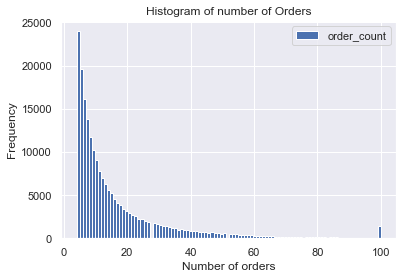

In [27]:
#plot histogram of orders

ax = orders_count.plot.hist(bins = 100)
ax.set_xlabel("Number of orders")
ax.set_title('Histogram of number of Orders')
ax.legend()

__Analysis__
- For every user we have around 4-100 order details ( including train and test)

#### 4.1.4 How many Orders with no reordered products ?

In [28]:
#Ques: How many Orders with no reordered products ?

orders_count = prior_train_orders.groupby(['order_id'])['reordered'].sum().reset_index(name = 'counts')
order_with_reordered_items , order_with_no_reordered_items= sum(orders_count['counts']!=0) , sum(orders_count['counts']==0)

#order_with_reordered_items/ total unique orders
print('Orders with reordered items :',order_with_reordered_items/prior_train_orders['order_id'].nunique())
print('Orders with no reordered items :',order_with_no_reordered_items/prior_train_orders['order_id'].nunique())

Orders with reordered items : 0.8813194412690899
Orders with no reordered items : 0.11868055873091014


__Analysis -__
- 12 % of orders have no reordered items, while rest ~88 % of orders contains reordered items

#### 4.1.5 Products - Frequently ordered products ?

In [29]:
print("There are total {} different products ".format(prior_train_orders['product_name'].nunique()))

There are total 49685 different products 


In [30]:
df = prior_train_orders.groupby(['product_name'])['product_name'].size().\
        reset_index(name = 'order_rate').sort_values(by ='order_rate', ascending = False)
df['order_rate'] = df['order_rate']/prior_train_orders['order_id'].nunique()
df.set_index('product_name', inplace = True)
df.round(5)

,order_rate
product_name,
Banana,0.14683
Bag of Organic Bananas,0.11803
Organic Strawberries,0.08236
Organic Baby Spinach,0.07522
Organic Hass Avocado,0.06601
...,...
Greek Blended Cherry Fat Free Yogurt,0.00000
All Natural Stevia Liquid Extract Sweetener,0.00000
"Frittata, Farmer's Market",0.00000


Text(0.5, 1.0, 'Frequently ordered product')

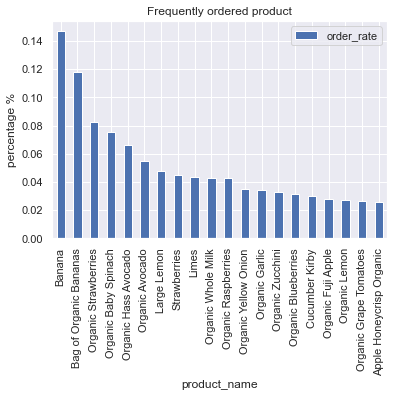

In [31]:
ax = df[:20].plot.bar()
ax.set_ylabel("percentage %")
ax.set_title('Frequently ordered product')

In [32]:
# print least frequently ordered product by count

print("Least frequently ordered product ")
print("\n",prior_train_orders['product_name'].value_counts()[-10:])

Least frequently ordered product 

 Lowfat Cherry Lime Supernova Kefir Cultured Milk Smoothie    1
Lindor Peppermint White Chocolate Truffles                   1
Pure Squeezed  Lemonade                                      1
Hot Oatmeal Multigrain Raisin                                1
Pure Peppermint Extract                                      1
Skin Firming Cellulite Gel Cream                             1
Buddy Bear Probiotic Orange Flavor Chewable                  1
Vanilla Bean Sheep Milk Ice Cream                            1
Imported Stout Draught Style                                 1
Cabernet Sauvignon 2015                                      1
Name: product_name, dtype: int64


__Analysis__

- It can be seen that most of the products which are ordered are organic foods / fresh fruits (especially Bananas)
- Bananas have highest order rate of 0.14.
- Least ordered products include Wasabi Cheddar Spreadable Cheese ,Vitamin D Gummies, Escapes Variety Pack etc

#### 4.1.6  Products - Frequently re-ordered products ?

In [33]:
#ques : Frequently reordered product ?
#percentage - of products reordered

df = prior_train_orders[prior_train_orders['reordered'] ==1].groupby(['product_name'])['product_name'].size().\
        reset_index(name = 'reorder_rate').sort_values(by ='reorder_rate', ascending = False)
df['reorder_rate'] = df['reorder_rate']/prior_train_orders[prior_train_orders['reordered'] ==1]['order_id'].nunique()
df.set_index('product_name', inplace = True)
df.round(5)

,reorder_rate
product_name,
Banana,0.14078
Bag of Organic Bananas,0.11166
Organic Strawberries,0.07272
Organic Baby Spinach,0.06610
Organic Hass Avocado,0.05974
...,...
Raspberry Cheesecake,0.00000
Liquid Vitamin B-Complex Natural Tangerine Flavor,0.00000
Oktoberfest Malt Liquor,0.00000


Text(0.5, 1.0, 'Frequently reordered product')

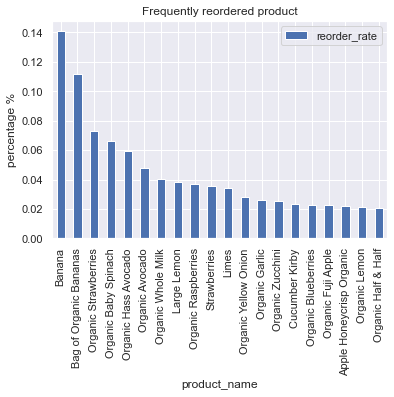

In [34]:
ax = df[:20].plot.bar()
ax.set_ylabel("percentage %")
ax.set_title('Frequently reordered product')

In [35]:
#frequently reordered product by count

print("\nLeast frequently reordered product ")
print("\n",prior_train_orders[prior_train_orders['reordered'] ==1]['product_name'].value_counts()[-10:])


Least frequently reordered product 

 Sweet Seaweed Snack                                                      1
Living Jewel Junmai Sake                                                 1
Peppermint/Banana Split Variety Pack Frozen Dairy Dessert Cones          1
White Honey Smoked 95% Fat Free Turkey                                   1
Garnishing Bag Bouquet                                                   1
Complete Omega Lemon Softgels                                            1
Fruity Red Sangria                                                       1
Cinnamon Coffee Cake                                                     1
Green Salsa Jalapeno                                                     1
Crystal Clear Decorative 60 Watt A Medium Base Ceiling Fan Light Bulb    1
Name: product_name, dtype: int64


__Analysis__:

- It can be seen that most of the products which are reordered are also organic foods / fresh fruits (especially Bananas). Same observation can be concluded fron product order rate above.
- Bananas have highest reorder rate of 0.14.
- Least reordered product were Simply Clean & Fresh HE Liquid Laundry Detergent Refreshing Breeze Scent, Ocean Breeze Conditioner etc

#### 4.1.7 Aisles - ordered / reordered

In [36]:
#aisles

print("There are total {} different aisles ".format(prior_train_orders['aisle'].nunique()))

There are total 134 different aisles 


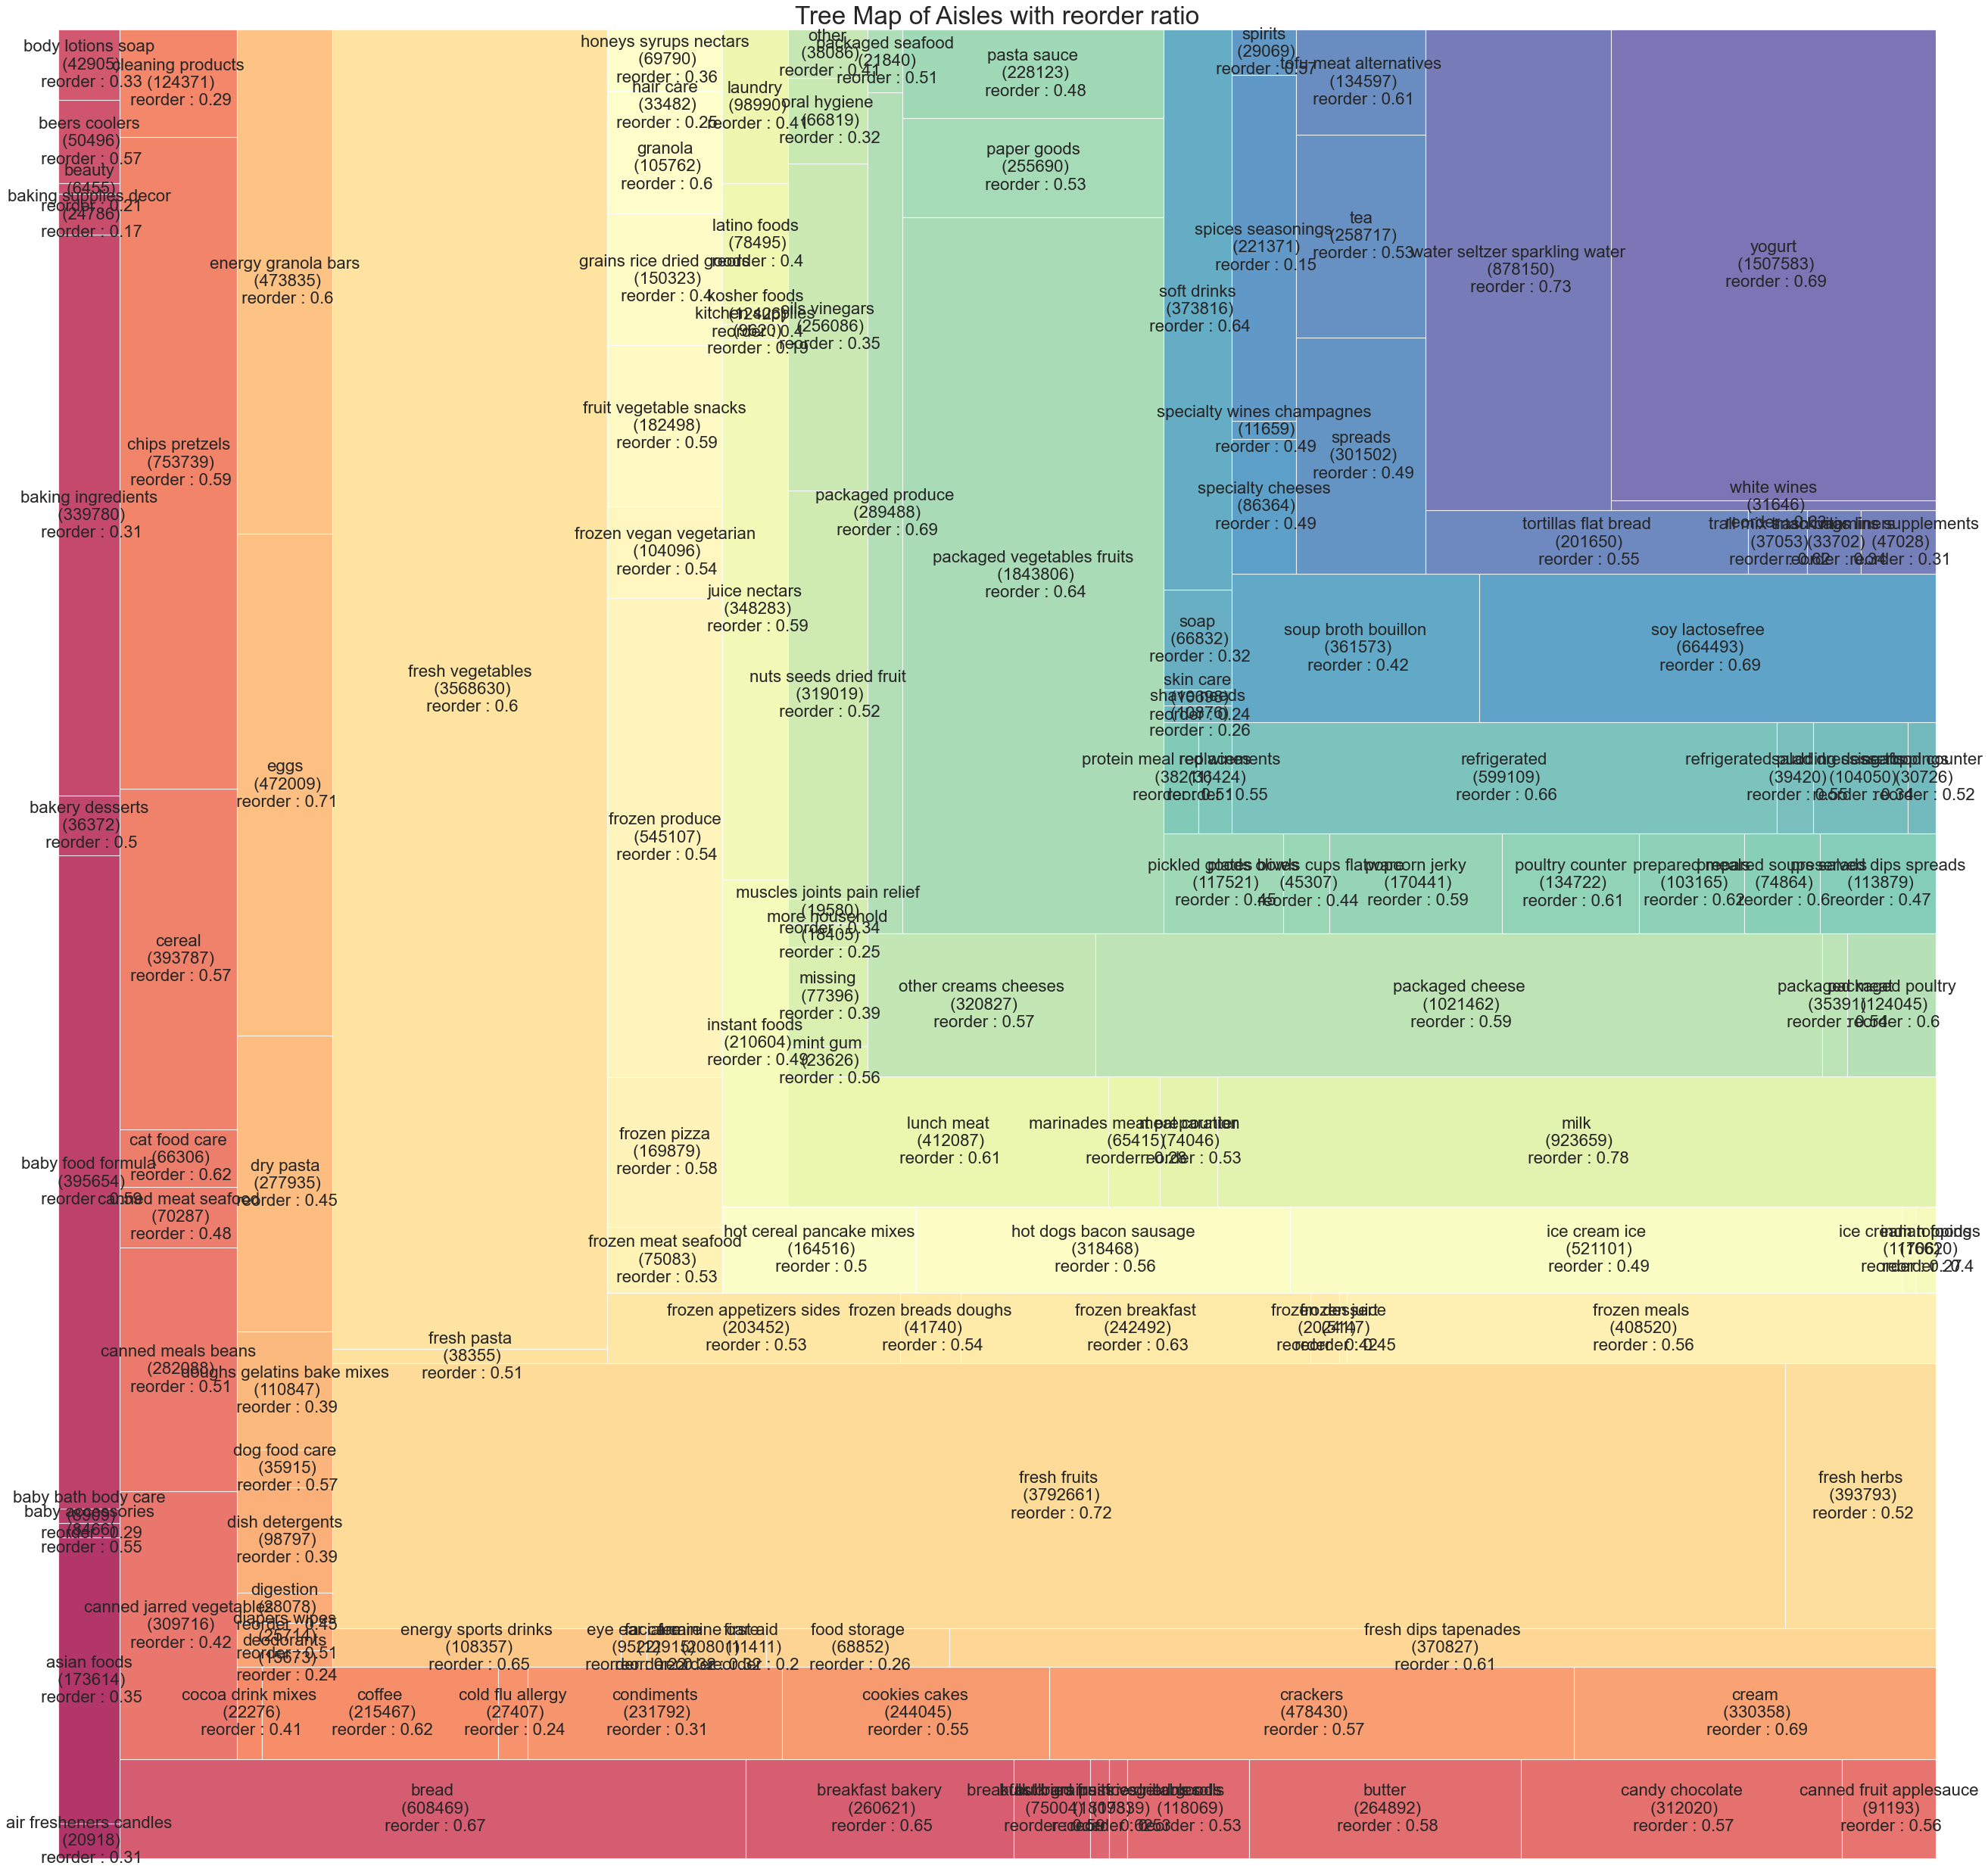

In [37]:
#plot tree map of aisles showing order_count and reorder rate
# ref: https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/

import squarify 

# Prepare Data
df = prior_train_orders.groupby(['aisle']).size().reset_index(name='order_count')
aisle_reorder_rate = prior_train_orders[prior_train_orders['reordered']==1].groupby(['aisle']).size().reset_index(name='reorder_rate')
df['reorder_rate'] = aisle_reorder_rate['reorder_rate']/df['order_count']

labels = df.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")" + "\n reorder : "+ str(round(x[2],2)) , axis=1)
sizes = df['order_count'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(40,40), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8, text_kwargs={'fontsize':20})

# Decorate
plt.title('Tree Map of Aisles with reorder ratio', fontsize = 30)
plt.axis('off')
plt.show()

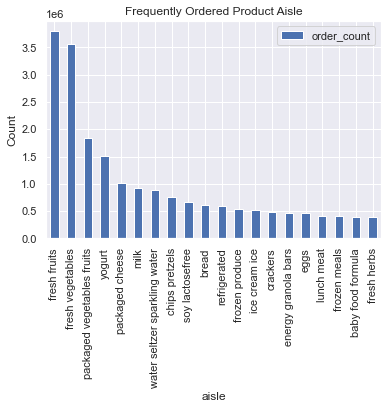

In [38]:
#plot bar plot of top 20 aisles based on order count

ax = df[['aisle','order_count']].sort_values(by='order_count', ascending = False)[:20].plot.bar(x = 'aisle', y='order_count')
ax.set_ylabel("Count")
ax.set_title('Frequently Ordered Product Aisle')
ax.legend()

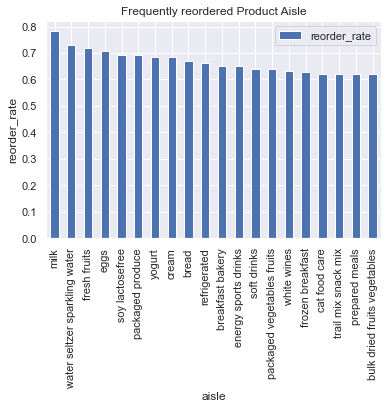

In [39]:
#plot bar plot of top 20 aisles based on their reorder rate

ax = df[['aisle','reorder_rate']].sort_values(by='reorder_rate', ascending = False)[:20].plot.bar(x = 'aisle', y='reorder_rate')
ax.set_ylabel("reorder_rate")
ax.set_title('Frequently reordered Product Aisle')
ax.legend()

In [40]:
# get most frequently reordered product from each aisle

df.sort_values(by = 'reorder_rate', axis=0, ascending=False, inplace = True)

print("Most frequently reordered product aisles")
df[:10]

Most frequently reordered product aisles


,aisle,order_count,reorder_rate
83,milk,923659,0.781812
131,water seltzer sparkling water,878150,0.729930
50,fresh fruits,3792661,0.718823
41,eggs,472009,0.706359
119,soy lactosefree,664493,0.692361
96,packaged produce,289488,0.691977
133,yogurt,1507583,0.686501
33,cream,330358,0.685184
11,bread,608469,0.670552
110,refrigerated,599109,0.663006


In [41]:
#get least frequently reordered product from each aisle

print("Least frequently reordered product aisles")
df[-10:]

Least frequently reordered product aisles


,aisle,order_count,reorder_rate
67,hair care,33482,0.246759
115,skin care,10698,0.242849
34,deodorants,15673,0.238818
29,cold flu allergy,27407,0.235341
44,eye ear care,9522,0.220542
8,beauty,6455,0.212858
47,first aid,11411,0.195864
76,kitchen supplies,9620,0.194802
7,baking supplies decor,24786,0.167595
122,spices seasonings,221371,0.152933


__Analysis__:
- As we can see, most products are ordered from Fresh Fruits and Fresh Vegetables aisles.
- Other frequently ordered items are from Yogurt , Packaged Vegetables and packaged cheese aisles.
- Least frequently ordered items are from Air fresheners, Baby accessories, Baby bath body care etc. aisles

- Milk, sparkling water, fruits, eggs, yogurt are most common aisles the product is reordered from, as they are items which are daily consumed, and one rarely switches from their usual meal plan. Also these are the products that lasts only few days , thus high reorder rate.
- On the other hand hair care, skin care, kitchen supplies are the one which lasts longer than other, hence low reorder rate

#### 4.1.8 Department - ordered/ reordered

In [42]:
#department

print("There are total {} different departments ".format(prior_train_orders['department'].nunique()))

There are total 21 different departments 


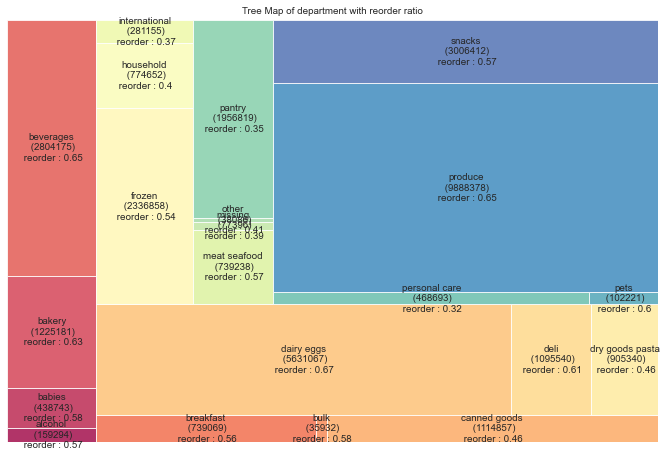

In [43]:
# get tree map of departments and display their order count and reorder rate
# ref: https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/

# Prepare Data
df = prior_train_orders.groupby(['department']).size().reset_index(name='order_count')
dept_reorder_rate = prior_train_orders[prior_train_orders['reordered']==1].groupby(['department']).size().reset_index(name='reorder_rate')
df['reorder_rate'] = dept_reorder_rate['reorder_rate']/df['order_count']

labels = df.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")" + "\n reorder : "+ str(round(x[2],2)) , axis=1)
sizes = df['order_count'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(12,8), dpi= 70)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8, text_kwargs={'fontsize':10})

# Decorate
plt.title('Tree Map of department with reorder ratio', fontsize = 10)
plt.axis('off')
plt.show()

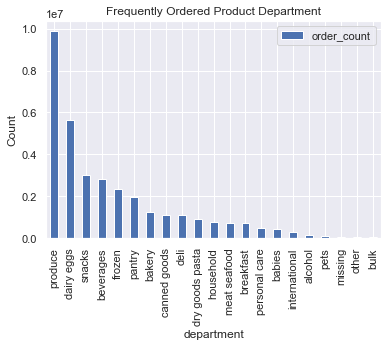

In [44]:
# plot departments by their order rate

ax = df[['department','order_count']].sort_values(by='order_count', ascending = False).plot.bar(x = 'department', y='order_count')
ax.set_ylabel("Count")
ax.set_title('Frequently Ordered Product Department')
ax.legend()

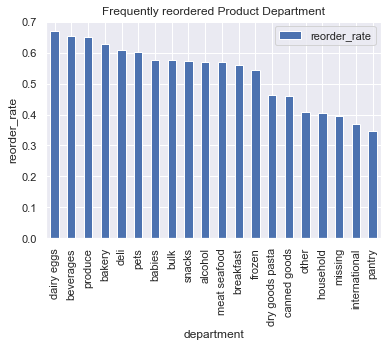

In [45]:
#plot bar plot of top 20 Department based on their reorder rate

ax = df[['department','reorder_rate']].sort_values(by='reorder_rate', ascending = False)[:20].plot.bar(x = 'department', y='reorder_rate')
ax.set_ylabel("reorder_rate")
ax.set_title('Frequently reordered Product Department')
ax.legend()

In [46]:
# get most frequently reordered product from each department

df.sort_values(by = 'reorder_rate', axis=0, ascending=False, inplace = True)

print("Most frequently reordered product departments")
df[:5]

Most frequently reordered product departments


,department,order_count,reorder_rate
7,dairy eggs,5631067,0.670161
3,beverages,2804175,0.653651
19,produce,9888378,0.650521
2,bakery,1225181,0.628381
8,deli,1095540,0.608130


In [47]:
#get least frequently reordered product from each department

print("Least frequently reordered product aisles")
df[-5:]

Least frequently reordered product aisles


,department,order_count,reorder_rate
11,household,774652,0.403339
14,missing,77396,0.394323
12,international,281155,0.369682
16,pantry,1956819,0.347400
17,personal care,468693,0.321863


Below we intend to get aisles for some departments to get an idea on what does a particular department have ?

In [48]:
depts_aisles = prior_train_orders.groupby(['department'])['aisle'].agg(lambda group: group.unique().tolist())\
                .reset_index(name = 'aisles')

In [49]:
dairy_eggs = depts_aisles.loc[depts_aisles['department']=='dairy eggs']['aisles'].tolist()
beverages = depts_aisles.loc[depts_aisles['department']=='beverages']['aisles'].tolist()
produce = depts_aisles.loc[depts_aisles['department']=='produce']['aisles'].tolist()
personal_care = depts_aisles.loc[depts_aisles['department']=='personal care']['aisles'].tolist()


In [50]:
dairy_eggs

[['yogurt',
  'packaged cheese',
  'other creams cheeses',
  'eggs',
  'soy lactosefree',
  'milk',
  'cream',
  'butter',
  'refrigerated pudding desserts',
  'specialty cheeses']]

In [51]:
beverages

[['energy sports drinks',
  'refrigerated',
  'water seltzer sparkling water',
  'juice nectars',
  'soft drinks',
  'coffee',
  'tea',
  'cocoa drink mixes']]

In [52]:
produce

[['fresh vegetables',
  'fresh fruits',
  'packaged vegetables fruits',
  'packaged produce',
  'fresh herbs']]

In [53]:
personal_care

[['cold flu allergy',
  'body lotions soap',
  'soap',
  'oral hygiene',
  'muscles joints pain relief',
  'hair care',
  'beauty',
  'deodorants',
  'facial care',
  'feminine care',
  'vitamins supplements',
  'digestion',
  'protein meal replacements',
  'shave needs',
  'first aid',
  'eye ear care',
  'skin care']]

__Analysis__

- As seen from departments analysis , most ordered products are from produce department which have fresh vegetables, fruits, herbs etc. But most reordered product department is dairy eggs having yogurt, milk, eegs, cheese etc.
- We see high reorder rate in organic foods and daily consumed items.
- Low reorder rate in personal care departments.

__Combining products , departments, aisles to see which product from which aisle and department was frequently reordered__

In [54]:
#
#reorder_rate = #times product been reordered / #times product was ordered

df = pd.DataFrame({'reorder_rate': prior_train_orders.groupby(['product_name','aisle','department','reordered'])['reordered'].\
                                                       count().groupby(level=0).\
                                                       apply(lambda x: x / float(x.sum()))}).reset_index()
df_reorder = df[df['reordered']==1].drop(['reordered'], axis =1)
df_reorder.sort_values(by = 'reorder_rate', ascending = False, inplace = True)

df_reorder

,product_name,aisle,department,reorder_rate
71716,Raw Veggie Wrappers,prepared meals,deli,0.942029
76468,Serenity Ultimate Extrema Overnight Pads,feminine care,personal care,0.933333
54354,Orange Energy Shots,energy sports drinks,beverages,0.923077
16298,Chocolate Love Bar,candy chocolate,snacks,0.921569
80019,Soy Powder Infant Formula,baby food formula,babies,0.914286
...,...,...,...,...
3855,"Allspice, Ground, Organic",spices seasonings,pantry,0.012821
56117,Organic Chinese Five Spice,spices seasonings,pantry,0.011236
62303,Organic Whole Nutmeg,spices seasonings,pantry,0.009434
55845,Organic Caraway Seeds,spices seasonings,pantry,0.007042


__Analysis__:

- We can see the products with high reorder rate are prepared meals, feminine care, sports drinks, baby food etc. 
- These products doesnt have high order rate , but they do have high reorder rate , probably because people doesnt change their preferences for some products over time.
- Panty items have very low reorder rate. Products include spices, Nutmeg , organic caraway seeds etc. We can assume that people switched their preferences on these products or they dont use these anymore.

#### 4.1.9 Add to cart Order

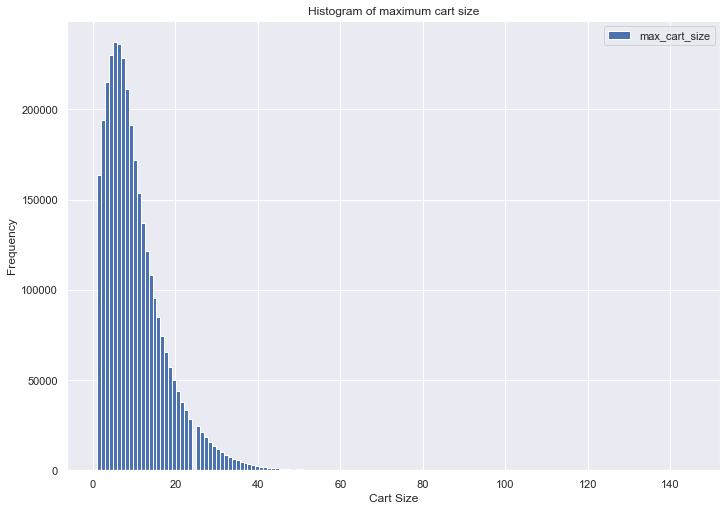

In [55]:
#plot histogram of maximum cart size  - > which is generated by add to cart order 

sns.set(rc={'figure.figsize':(11.7,8.27)})
max_cart_size = prior_train_orders.groupby(['order_id'])['add_to_cart_order'].aggregate(np.max)\
                                                            .reset_index(name = 'max_cart_size')
ax = max_cart_size['max_cart_size'].plot.hist(bins = 150, color = 'b')
ax.set_xlabel("Cart Size")
ax.set_title('Histogram of maximum cart size')
ax.legend()

In [56]:
max_cart_size['max_cart_size'].value_counts()[:1]

5    237225
Name: max_cart_size, dtype: int64

__Analysis__:

We have a right skewed distribution of maximum cart size for every order, with mode = 5. There are very few order with cart size > 40 and all the way up to 145.

Before treating values here as an outlier, we need to account below facts.
- add_to_cart_order represents the order the product in the cart.
- we can get many minute relationships between product and user based on their purchases.
- as we need to get reorder probabilities for every product that user ordered, discarding data shouldn't be an option 

#### 4.1.10 Day of week

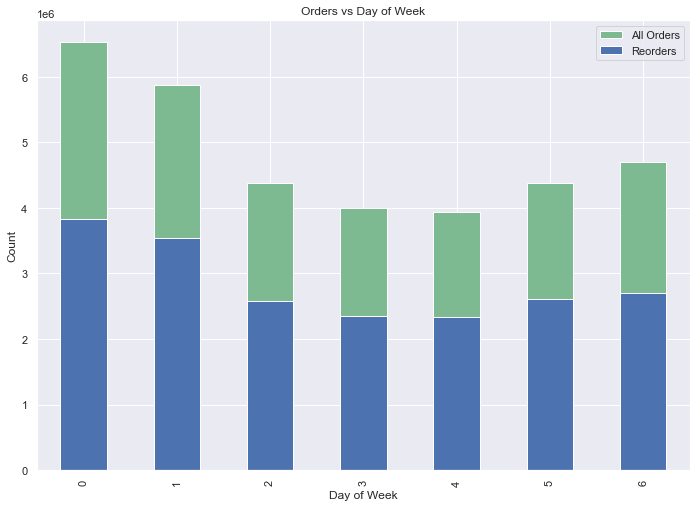

In [52]:
# how many products were ordered and reordered on a particular day of week

sns.set_theme(context='notebook', style='darkgrid', palette="crest")
ax = prior_train_orders['order_dow'].value_counts().plot.bar()
ax = prior_train_orders[prior_train_orders['reordered']==1].groupby(['order_dow']).size().plot.bar(color = 'b')
ax.set_xlabel("Day of Week")
ax.set_ylabel("Count")
ax.set_title('Orders vs Day of Week')
ax.legend(["All Orders", "Reorders"])

__Analysis__
- Assuming that the week starts from Sunday, most shopping is done on Sundays and Mondays. Also least orders were placed on thursday. People tend to restock there supplies on sundays.
- Reorders w.r.t to days of week is proportionally same as all orders.

#### 4.1.11 Hour of Day

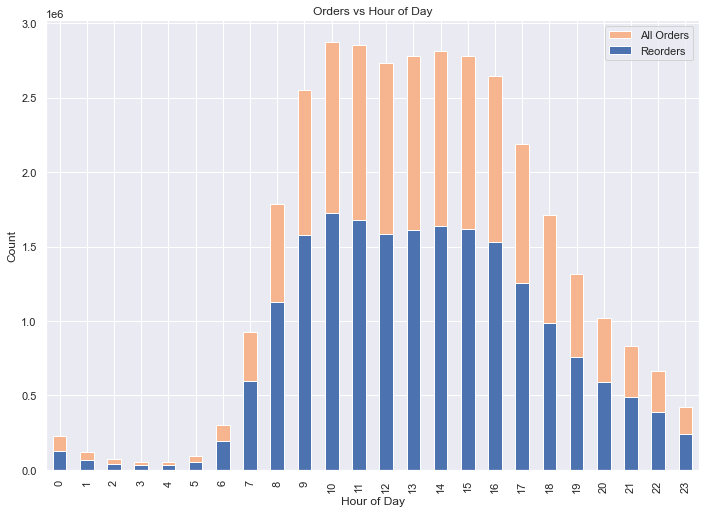

In [53]:
#how many products were ordered and reordered on a particular hour of day

sns.set_theme(context='notebook', style='darkgrid', palette="rocket_r")
ax = prior_train_orders['order_hour_of_day'].value_counts().plot.bar()
ax = prior_train_orders[prior_train_orders['reordered']==1].groupby(['order_hour_of_day']).size().plot.bar(color = 'b')
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Count")
ax.set_title('Orders vs Hour of Day')
ax.legend(["All Orders", "Reorders"])

__Analysis__
- Most orders are placed from Early morning to midnight, and very few orders placed from midnight to early morning.


#### 4.1.13 Days since prior order

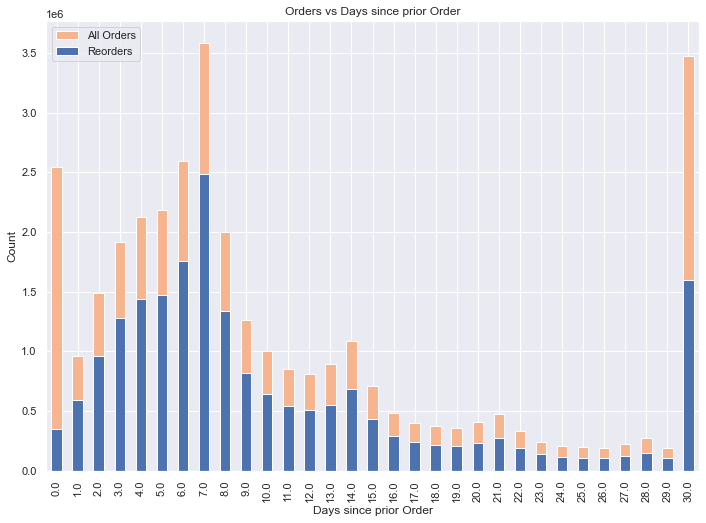

In [54]:
# After how mamy days user ordered / reordered a product

sns.set_theme(context='notebook', style='darkgrid', palette="rocket_r")
ax = prior_train_orders['days_since_prior_order'].value_counts().plot.bar()
ax = prior_train_orders[prior_train_orders['reordered']==1].groupby(['days_since_prior_order']).size().plot.bar(color = 'b')
ax.set_xlabel("Days since prior Order")
ax.set_ylabel("Count")
ax.set_title('Orders vs Days since prior Order')
ax.legend(["All Orders", "Reorders"])

__Analysis__:
- Most people restock after a week or a month. It seems, some people prefer buy a week / month supplies at once.
- People who are buying at Day 0, are probably new customers, but we can see a small rate of reorder implying that users tend to place multiple orders on Day 0 too. 
- Probably here 30 days represents the upper limit, and not necessarily any particular month.
- There is a continous spike in orders from day 1 to day 6, shows that some people are frequent buyers wit short window of restocking 

### Analysis of weekly buyers and monthly buyers

#### Frequently brought product by weekly buyers

Text(0.5, 1.0, 'Frequently reordered product by weekly buyers')

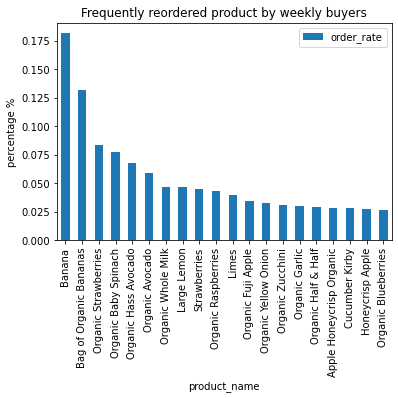

In [19]:
df = prior_train_orders[(prior_train_orders['days_since_prior_order']==7.0) & (prior_train_orders['reordered']==1.0)].groupby('product_name')['product_name'].size().\
            reset_index(name = 'order_rate').sort_values(by = 'order_rate', ascending = False)
df['order_rate'] = df['order_rate']/ prior_train_orders[(prior_train_orders['days_since_prior_order']==7.0) & (prior_train_orders['reordered']==1.0)]['order_id'].nunique()
df.set_index('product_name', inplace = True)

#top 20 frequently reordered product
ax = df[:20].plot.bar()
ax.set_ylabel("percentage %")
ax.set_title('Frequently reordered product by weekly buyers')

In [20]:
df[:20]

,order_rate
product_name,
Banana,0.181724
Bag of Organic Bananas,0.132152
Organic Strawberries,0.083824
Organic Baby Spinach,0.077275
Organic Hass Avocado,0.068253
Organic Avocado,0.058786
Organic Whole Milk,0.047242
Large Lemon,0.047144
Strawberries,0.044832


Text(0.5, 1.0, 'Frequently reordered product by monthly buyers')

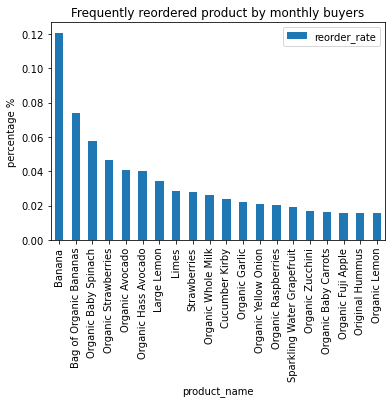

In [21]:
df = prior_train_orders[(prior_train_orders['days_since_prior_order']==30.0) & (prior_train_orders['reordered']==1.0)].\
        groupby('product_name')['product_name'].size().\
        reset_index(name = 'reorder_rate').sort_values(by = 'reorder_rate', ascending = False)
df['reorder_rate'] = df['reorder_rate']/prior_train_orders[(prior_train_orders['days_since_prior_order']==30.0) & (prior_train_orders['reordered']==1)]\
                    ['order_id'].nunique()
df.set_index('product_name', inplace = True)

#top 20 frequently reordered product
ax = df[:20].plot.bar()
ax.set_ylabel("percentage %")
ax.set_title('Frequently reordered product by monthly buyers')

In [22]:
df[:20]

,reorder_rate
product_name,
Banana,0.120750
Bag of Organic Bananas,0.074116
Organic Baby Spinach,0.057675
Organic Strawberries,0.046598
Organic Avocado,0.040948
Organic Hass Avocado,0.040223
Large Lemon,0.034213
Limes,0.028454
Strawberries,0.027699


__Analysis__:

- Weekly/monthly buyers tend to buy similar products
- These products, in general, have highest reorder rate irrespective of day of purchase

<AxesSubplot:>

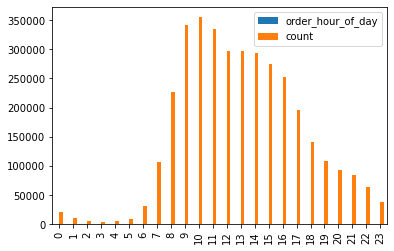

In [94]:
prior_train_orders[(prior_train_orders['days_since_prior_order']==7.0)].\
    groupby('order_hour_of_day')['order_hour_of_day'].count().\
    reset_index(name = 'count').plot.bar()

<AxesSubplot:>

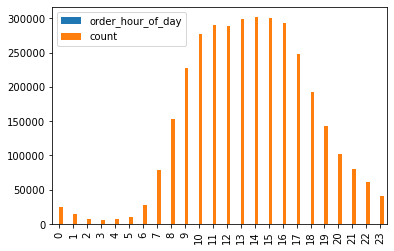

In [95]:
prior_train_orders[(prior_train_orders['days_since_prior_order']==30.0)].\
    groupby('order_hour_of_day')['order_hour_of_day'].count().\
    reset_index(name = 'count').plot.bar()

__Analysis:__

- Weekly/monthly buyer's time of purchase ,is similar to the normal purchase time pattern, which can be seen from plot (4.1.11) Hour of Day


### 4.2 Bivariate Analysis

#### 4.2.1 How day of week and hour of day impact product order/reorder ?

In [48]:
order_day = prior_train_orders.groupby(['order_dow'])['order_id'].count().reset_index(name = 'count')

In [49]:
#ques : how many products were reordered per day?

reorder_day = prior_train_orders[prior_train_orders['reordered']==1].groupby(['order_dow','order_hour_of_day'])['order_id'].count().reset_index(name = 'reorder_rate')
reorder_day = pd.merge(reorder_day, order_day, on = 'order_dow', how = 'left')
reorder_day['reorder_rate'] = reorder_day['reorder_rate']/reorder_day['count']
reorder_day.drop('count', axis = 1, inplace = True)
reorder_day = reorder_day.pivot('order_dow','order_hour_of_day','reorder_rate')
reorder_day = pd.DataFrame(reorder_day.to_records())
reorder_day.set_index("order_dow", inplace = True)
reorder_day

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
0,0.003569,0.002003,0.001152,0.000816,0.000734,0.001113,0.003477,0.013783,0.030964,0.043079,0.049074,0.049980,0.049616,0.051980,0.052577,0.051500,0.046587,0.036508,0.026347,0.020451,0.017612,0.015058,0.011650,0.006853
1,0.003876,0.001901,0.001056,0.000716,0.000806,0.001594,0.006162,0.019530,0.038739,0.057807,0.060637,0.054517,0.048405,0.047676,0.047370,0.045620,0.042959,0.034735,0.026416,0.020138,0.015485,0.012374,0.009331,0.005821
2,0.003996,0.001952,0.001122,0.000971,0.000924,0.001850,0.006600,0.018659,0.033406,0.048240,0.051230,0.049132,0.045331,0.046056,0.046363,0.046002,0.045726,0.037919,0.030994,0.023377,0.017665,0.014161,0.010909,0.007136
3,0.003951,0.001902,0.001238,0.000838,0.000988,0.001856,0.006713,0.018484,0.032076,0.044174,0.048326,0.047311,0.044449,0.045616,0.045376,0.047450,0.046031,0.039393,0.032025,0.024665,0.018410,0.015161,0.012387,0.007467
4,0.003636,0.001956,0.001167,0.000939,0.001064,0.001935,0.006760,0.019075,0.031919,0.043312,0.047918,0.046579,0.044294,0.045310,0.045854,0.046413,0.045973,0.039467,0.032050,0.025993,0.020395,0.017036,0.013853,0.008225
5,0.003866,0.002017,0.001265,0.001085,0.001246,0.002161,0.006926,0.019394,0.033038,0.046145,0.050903,0.049886,0.046430,0.047044,0.048975,0.048571,0.046317,0.037880,0.029896,0.022780,0.017518,0.014026,0.011095,0.007436
6,0.003895,0.002295,0.001408,0.000962,0.000999,0.001416,0.004487,0.016525,0.032950,0.042143,0.046748,0.047336,0.046944,0.047479,0.049617,0.047506,0.044149,0.036237,0.028780,0.021727,0.016806,0.014701,0.012001,0.008133


In [135]:
#ques : how many products were reordered per hour?

reorder_day_hour = reorder_day_hour.pivot('order_dow','order_hour_of_day','reorder_rate')
reorder_day_hour = pd.DataFrame(reorder_day_hour.to_records())
reorder_day_hour.set_index("order_dow", inplace = True)
reorder_day_hour

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
0,0.576550,0.553474,0.554843,0.568533,0.548804,0.593939,0.623720,0.641375,0.628425,0.608782,0.590530,0.578722,0.575781,0.578439,0.576480,0.578859,0.576589,0.572274,0.573635,0.583387,0.596562,0.608958,0.599885,0.598522
1,0.590223,0.591805,0.556773,0.575907,0.597298,0.625008,0.659281,0.671103,0.661747,0.650900,0.626395,0.607933,0.592622,0.589225,0.590289,0.582638,0.579127,0.579337,0.573562,0.571607,0.576382,0.582751,0.577297,0.577697
2,0.565236,0.560328,0.565167,0.578346,0.566349,0.611795,0.639887,0.642499,0.632594,0.621359,0.603170,0.588945,0.580363,0.579495,0.582892,0.579705,0.582220,0.573174,0.573160,0.574400,0.567638,0.579992,0.572223,0.574320
3,0.554133,0.535516,0.543409,0.549647,0.549194,0.605566,0.632678,0.641998,0.621488,0.613189,0.593657,0.584359,0.576467,0.579034,0.573884,0.580590,0.577596,0.577870,0.576167,0.575149,0.579100,0.581025,0.583596,0.569703
4,0.556915,0.540088,0.545530,0.561249,0.584238,0.607564,0.640583,0.636789,0.623603,0.608061,0.594486,0.586491,0.580078,0.584514,0.584366,0.586248,0.584938,0.587255,0.583577,0.581859,0.592002,0.595699,0.583805,0.571182
5,0.548980,0.550912,0.560946,0.546990,0.592179,0.616801,0.630476,0.632785,0.622217,0.617564,0.604645,0.593502,0.584064,0.588443,0.595649,0.596224,0.596805,0.588618,0.576357,0.571663,0.586883,0.595490,0.592294,0.580418
6,0.556838,0.565372,0.560270,0.543677,0.566370,0.591974,0.622106,0.636951,0.621953,0.600847,0.580525,0.569842,0.566758,0.563666,0.570564,0.564776,0.559598,0.553762,0.562518,0.564884,0.576726,0.588330,0.587386,0.581613


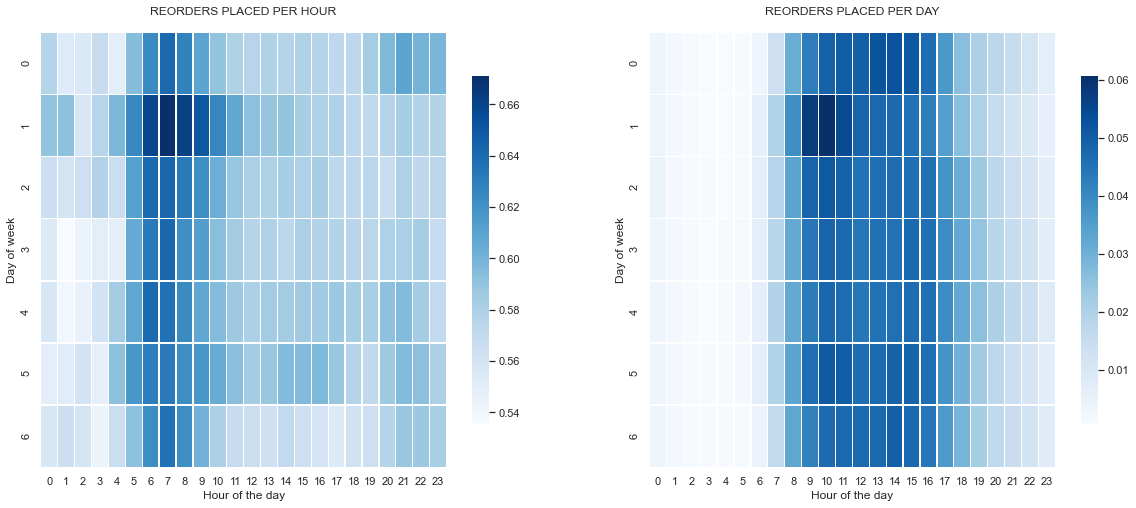

In [136]:
##plot heatmap to visualize dense portions of orders in a time frame of 24x7

# figure
fig, ax = plt.subplots(1,2, figsize=(20, 8))

# plot heatmap
sns.heatmap(reorder_day_hour, cmap="Blues", linewidth=0.3, cbar_kws={"shrink": .8}, ax = ax[0])
# axis labels
ax[0].set_xlabel('Hour of the day')
ax[0].set_ylabel('Day of week')
ax[0].set_title('Reorders placed per hour\n'.upper(), loc='center')

# plot heatmap
sns.heatmap(reorder_day, cmap="Blues", linewidth=0.3, cbar_kws={"shrink": .8}, ax = ax[1])
# axis labels
ax[1].set_xlabel('Hour of the day')
ax[1].set_ylabel('Day of week')
ax[1].set_title('Reorders placed per day\n'.upper(), loc='center')

plt.show()

- first plot describes reorder_rate of every day w.r.t to orders placed at that hour
- second plot describes reorder_rate of every day w.r.t to orders placed on that day

__Analysis__:

- from first plot we can see that of all orders that were placed on any hour, most reorders were placed on day 1 ( probably Monday) from 5 AM - 9 AM.
- Same pattern can be seen on any day between 5 AM - 9 AM.
- from second plot we can see that of all orders that were placed on any day, most reorders were placed from 8 AM - 4 PM, on any given day .

#### 4.2.2 Products vs hour of the day / day of week
#### Frequently brought product on any hour/day

In [77]:
#get row with maximum value after groupby
#ref:https://stackoverflow.com/a/15705958/11533069

x = prior_train_orders.groupby(['order_dow','order_hour_of_day','product_name'])['product_name'].size().reset_index(name = 'count')
idx = x.groupby(['order_dow','order_hour_of_day'], sort=False)['count'].transform(max) == x['count']
x = x[idx].drop_duplicates(subset=['order_dow','order_hour_of_day'], keep='first')
x = x.pivot(index = 'order_dow',columns = 'order_hour_of_day',values = 'product_name')
x

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
0,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana
1,Bag of Organic Bananas,Banana,Banana,Bag of Organic Bananas,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana
2,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana
3,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Bag of Organic Bananas
4,Bag of Organic Bananas,Bag of Organic Bananas,Banana,Bag of Organic Bananas,Bag of Organic Bananas,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana
5,Banana,Bag of Organic Bananas,Bag of Organic Bananas,Bag of Organic Bananas,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana
6,Banana,Banana,Bag of Organic Bananas,Banana,Bag of Organic Bananas,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana,Banana


__Analysis__:

- we can see that on any day - any hour most frequently ordered product is Banana and Bag of organic bananas

#### 4.2.3  aisles vs hour of the day vs day of week

we will check from which aisles products were frequently ordered / reordered  every hour

In [78]:
#ques : most frequently ordered product aisle by hour ?

#get row with maximum value after groupby
#ref:https://stackoverflow.com/a/15705958/11533069

x = prior_train_orders.groupby(['order_dow','order_hour_of_day','aisle'])['aisle'].size().reset_index(name = 'count')
idx = x.groupby(['order_dow','order_hour_of_day'], sort=False)['count'].transform(max) == x['count']
x = x[idx].drop_duplicates(subset=['order_dow','order_hour_of_day'], keep='first')
x = x.pivot(index = 'order_dow',columns = 'order_hour_of_day',values = 'aisle')
x

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
0,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh fruits,fresh fruits,fresh fruits,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits
1,fresh fruits,fresh vegetables,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits
2,fresh fruits,fresh vegetables,fresh vegetables,fresh vegetables,fresh fruits,fresh vegetables,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits
3,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits
4,fresh vegetables,fresh vegetables,fresh vegetables,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh vegetables
5,fresh vegetables,fresh vegetables,fresh fruits,fresh vegetables,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh vegetables,fresh vegetables
6,fresh vegetables,fresh vegetables,fresh fruits,fresh vegetables,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh fruits,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh vegetables,fresh fruits,fresh vegetables,fresh fruits,fresh vegetables,fresh vegetables,fresh vegetables


#### 4.2.4 department vs hour of the day vs day of week

we will check from which department products were frequently ordered / reordered every hour

In [79]:
# department vs hour of the day

#ques : most frequently ordered product department by hour ?

#get row with maximum value after groupby
#ref:https://stackoverflow.com/a/15705958/11533069

x = prior_train_orders.groupby(['order_dow','order_hour_of_day','department'])['department'].size().reset_index(name = 'count')
idx = x.groupby(['order_dow','order_hour_of_day'], sort=False)['count'].transform(max) == x['count']
x = x[idx].drop_duplicates(subset=['order_dow','order_hour_of_day'], keep='first')
x = x.pivot(index = 'order_dow',columns = 'order_hour_of_day',values = 'department')
x

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,,,,
0,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce
1,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce
2,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce
3,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce
4,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce
5,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce
6,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce,produce


__Analysis__:

- It can be seen that most frequently bought product on any given day at any time is Bananas
- Most frequently shopped aisle on any given day at any time is Fresh fruits and Fresh vegetables
- Most frequently shopped department on any given day at any time is produce

### 4.3  Other Insights

#### 4.3.1 products which were never ordered / reordered ?

In [78]:
#products which were never ordered

products[(~products.product_name.isin(prior_train_orders.product_name))]

,product_id,product_name,aisle_id,department_id
3629,3630,Protein Granola Apple Crisp,57,14
7044,7045,Unpeeled Apricot Halves in Heavy Syrup,88,13
46624,46625,Single Barrel Kentucky Straight Bourbon Whiskey,31,7


In [79]:
#products which were never reordered

df_reorder = df[(df['reordered']==0) & (df['reorder_rate']==float(1.0))]\
            .drop(['reordered','reorder_rate'], axis =1)
df_reorder

,product_name,aisle,department
4,#2 Mechanical Pencils,more household,household
9,'Swingtop' Premium Lager,beers coolers,alcohol
14,".5\"" Waterproof Tape",first aid,personal care
51,007 Vodka With Martini Glasses,spirits,alcohol
82,1% Hydrocortisone Anti-Itch Liquid Maximum Str...,first aid,personal care
...,...,...,...
95115,Zipper Quart Size Freezer Bags,food storage,household
95128,Ziti Rigate Penne,dry pasta,dry goods pasta
95161,Zyflamend Whole Body Liquid Vcaps,vitamins supplements,personal care
95192,"flings! Laundry Detergent Pacs, Original, 57 C...",laundry,household


__Analysis__:

- These 3 products (Protein Granola Apple Crisp	, Unpeeled Apricot Halves in Heavy Syrup , Single Barrel Kentucky Straight Bourbon Whiskey) which were never ordered. May be their alternatives were ordered.
- Of all 49685 products 4082 products were never reordered.
- Products which were never reordered, includes very specific items such as ".5\" Waterproof Tape", "007 Vodka With Martini Glasses", "'Swingtop' Premium Lager", we can assume that either consumer didnt like them or he switched his preferences. Looking at household items like "Zipper Quart Size Freezer Bags", "flings! Laundry Detergent Pacs, Original", we cant definitely say that preferences were switched, since they are type of products which lasts long and consumer might consider reordering them in future.

#### 4.3.2 Maximum cart size after N days since prior order ?

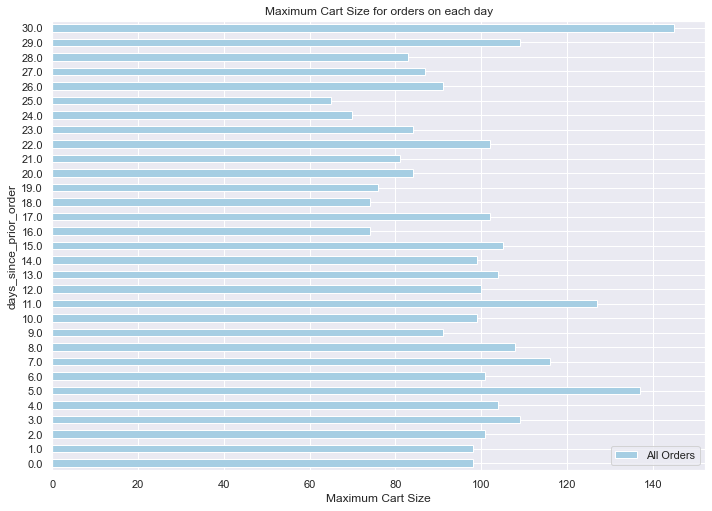

In [75]:
#ques : Average cart size after N days since prior order ?

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = prior_train_orders.groupby(['days_since_prior_order'])['add_to_cart_order'].aggregate(np.max).plot(kind='barh',colormap='Paired')
ax.set_xlabel("Maximum Cart Size")
ax.set_title('Maximum Cart Size for orders on each day')
ax.legend(["All Orders"])

__Analysis__:
- As it was expected, users with 30 days gap between consecutive orders have Largest cart size. i.e. tends to order more products
- Same observation can be seen with 29 days, 11 days, 5 days gap also.
- Users placing order on Day 0, have maximum cart size of around 100, these include both first time orders and multiple orders

- Also, average cart size for orders on any day is around 8.

#### 4.3.3 How much position of product in the cart impact reorder ?

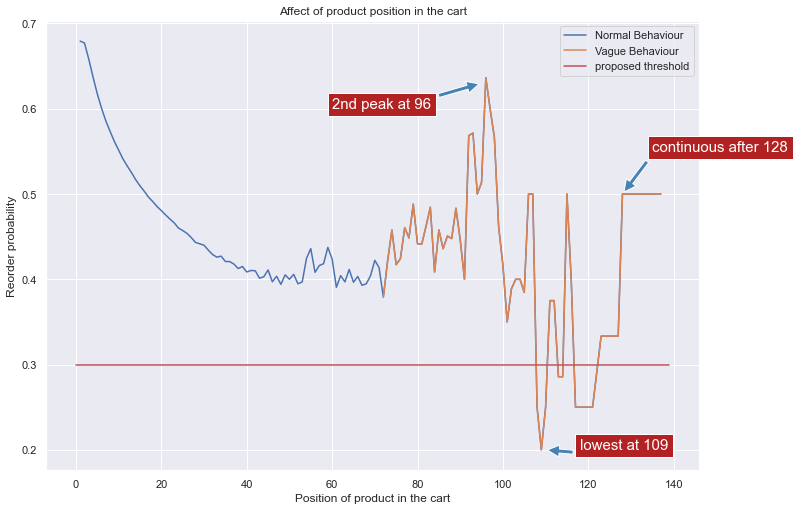

In [81]:
#ques : How much position of product in the cart impact reorder ?

df = pd.DataFrame({'reorder_rate': prior_train_orders.groupby(['add_to_cart_order','reordered'])['reordered'].\
                                                       count().groupby(level=0).\
                                                       apply(lambda x: x / float(x.sum()))}).reset_index()
ax = df[df['reordered']==1].set_index('add_to_cart_order')['reorder_rate'].plot()
ax = df[df['reordered']==1].set_index('add_to_cart_order')['reorder_rate'][71:].plot()
x = [*range(0,140)]
y = [0.3 for _ in range(140)]
ax.plot(x, y, '-r')
ax.set_xlabel('Position of product in the cart')
ax.set_ylabel('Reorder probability')
ax.set_title('Affect of product position in the cart')

#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html
ax.annotate('lowest at 109', xy=(110, 0.2), xytext=(118, 0.2),
             bbox=dict(boxstyle='square', fc='firebrick'),
             arrowprops=dict(facecolor='steelblue', shrink=0.05), fontsize=15, color='white')
ax.annotate('continuous after 128', xy=(128, 0.5), xytext=(135, 0.55),
             bbox=dict(boxstyle='square', fc='firebrick'),
             arrowprops=dict(facecolor='steelblue', shrink=0.05), fontsize=15, color='white')
ax.annotate('2nd peak at 96', xy=(95, 0.63), xytext=(60, 0.6),
             bbox=dict(boxstyle='square', fc='firebrick'),
             arrowprops=dict(facecolor='steelblue', shrink=0.05), fontsize=15, color='white')
ax.legend(["Normal Behaviour", "Vague Behaviour", "proposed threshold"])

__Analysis__:

- We see a normal decrease in reorder probability when the position of product is increased till 71.
- But there is huge probability changes after position is increased from 71.
- The lowest reorder probability is somewhere around 0.2 when position is 109
- Position from 128 to 137 shows continous 50 % reorder probability.
- We can assume that for a product with position greater than 100 have very low probability of being reordered (below 0.3)
- Since the reorder probability of a product will depend on product position in the cart and product itself, the vague behaviour can be assumed to be the result of reshuffled position of a product with high reorder probability

#### 4.3.4 Are there any users whose order contains only reordered products ?

In [82]:
# Are there any users whose order contains only reordered products ?

df = prior_train_orders.groupby(['user_id','order_id','reordered'])['reordered'].count()
df = (df / df.groupby(level=1).sum()).reset_index(name = 'reorder_prob')
df = pd.DataFrame(df[(df['reordered']==1) & (df['reorder_prob']==1.0)]['user_id'].value_counts().reset_index(name = 'count'))
df.columns = ['user_id', 'count']

#top 10 user_id with most number of orders with all reordered products
df[:10]

,user_id,count
0,99753,99
1,26489,96
2,100935,94
3,17997,94
4,69919,93
5,175680,92
6,140753,91
7,145481,91
8,127577,90
9,82414,90


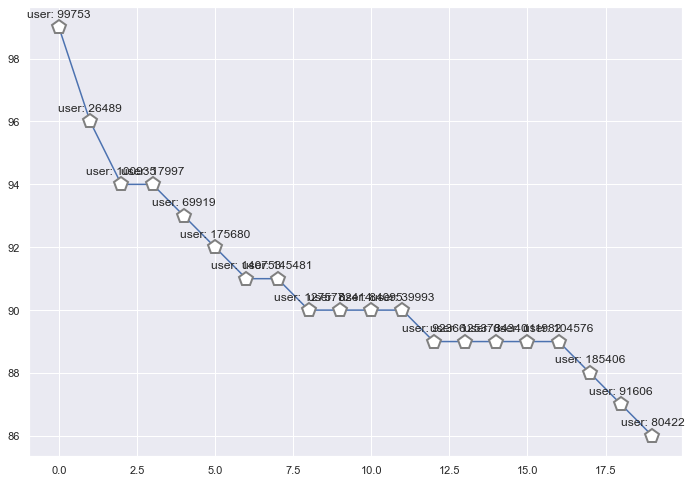

In [83]:
usr_ids = df['user_id'][:20].tolist()
counts = df['count'][:20].tolist()

#https://jakevdp.github.io/PythonDataScienceHandbook/04.02-simple-scatter-plots.html
plt.plot(counts)
for i,c in enumerate(counts):
    plt.plot(i, c, '-p', color='gray', markersize=15, linewidth=4,
         markerfacecolor='white',markeredgecolor='gray',markeredgewidth=2)
    plt.annotate("user: "+str(usr_ids[i]), # this is the text
                 (i,c), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') 

__Analysis__:

- User_id 99753 have 99 orders which contains only reordered items
- Followed by User 26489 and 100935